<a href="https://colab.research.google.com/github/Laeti-dev/Project4-Credit-Scoring-Model/blob/EDA/ikusawa_laetitia_1_notebook_0824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on [this kaggle notebook](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Read-in-Data)

# Imports

In [126]:
# check if the notebook is on colab
import os

if os.path.exists("/content"):
    path = "/content"
    # install dependencies
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install scikit-learn
else:
    path = "./data"


In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

# Exploration

There are 9 data files and 1 file explaining the variables that we'll load to understand our data.

## Columns description

In [484]:
columns_description = pd.read_csv(
    f"{path}/HomeCredit_columns_description.csv", encoding="latin1", index_col=0
)


In [485]:
columns_description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [486]:
application_description = columns_description[columns_description['Table'] == 'application_{train|test}.csv']

We will work on the application_train file to start with because it contains our target.

## Application

In [487]:
application_train = pd.read_csv(f"{path}/application_train.csv")
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [488]:
application_train.shape

(307511, 122)

The training dataset has 307,511 rows where each row is a loan application and 122 columns including our target (TARGET).

In [489]:
application_test = pd.read_csv('./data/application_test.csv')
application_test.shape

(48744, 121)

The testing dataset contains only 48,744 rows and does not contains a target to évaluet the prediction.

Lest's explore our train data

# EDA

## Target column distribution

In [531]:
application_train['TARGET'].value_counts()

TARGET
0    282682
1     24825
Name: count, dtype: int64

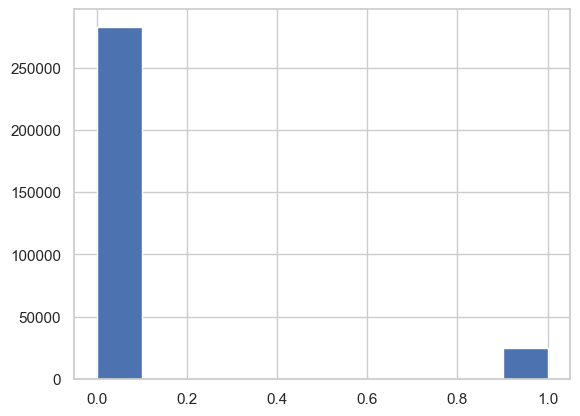

In [532]:
fig, ax = plt.subplots()

ax.hist(application_train['TARGET'])
plt.show()

We observe that this is an imbalanced class. A lot more loans have been reapaid con time than loans that were not repaid.

## Missing values

In [533]:
def missing_values_table(df):
    """
    Takes the dataframe and display missing values count and ratio
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Ratio of missing values
    mis_val_ratio = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_ratio], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by ratio of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [534]:
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 123 columns.
There are 68 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,214862,69.9
COMMONAREA_AVG,214862,69.9
COMMONAREA_MEDI,214862,69.9
NONLIVINGAPARTMENTS_MEDI,213512,69.4
NONLIVINGAPARTMENTS_MODE,213512,69.4
NONLIVINGAPARTMENTS_AVG,213512,69.4
FONDKAPREMONT_MODE,210293,68.4
LIVINGAPARTMENTS_MEDI,210197,68.4
LIVINGAPARTMENTS_AVG,210197,68.4
LIVINGAPARTMENTS_MODE,210197,68.4


In [535]:
# get a list of columns with missing values
missing_columns = [col for col in application_train.columns if application_train[col].isnull().any()]

In [536]:
application_train[missing_columns].head()

,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,24700.5,351000.0,Unaccompanied,-637.0,NaN,Laborers,1.0,0.083037,0.262949,0.139376,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35698.5,1129500.0,Family,-1188.0,NaN,Core staff,2.0,0.311267,0.622246,NaN,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,Unaccompanied,-225.0,26.0,Laborers,1.0,NaN,0.555912,0.729567,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,297000.0,Unaccompanied,-3039.0,NaN,Laborers,2.0,NaN,0.650442,NaN,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,Unaccompanied,-3038.0,NaN,Core staff,1.0,NaN,0.322738,NaN,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


## Columns type

In [537]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    66
int64      40
object     16
bool        1
Name: count, dtype: int64

In [538]:
categorical_vars = application_train.select_dtypes(include='object').columns.tolist()
print(categorical_vars)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [539]:
quantitative_vars = application_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(quantitative_vars)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEAR

### Categorical variables

In [540]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [541]:
application_train['CODE_GENDER'].unique()

array(['M', 'F'], dtype=object)

In [542]:
application_train.loc[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM


In [543]:
# drop rows with XNA
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']

In [544]:
application_train['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

In [545]:
application_train['EMERGENCYSTATE_MODE'].value_counts()

EMERGENCYSTATE_MODE
No     159425
Yes      2328
Name: count, dtype: int64

Get details on the variables

In [546]:
# Set the option to display full length of a column
pd.set_option('display.max_colwidth', None)
application_description[application_description['Row'].isin(categorical_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,CODE_GENDER,Gender of the client,NaN
7,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
14,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,NaN
15,NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave, )",NaN
16,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN
17,NAME_FAMILY_STATUS,Family status of the client,NaN
18,NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",NaN
31,OCCUPATION_TYPE,What kind of occupation does the client have,NaN


In [547]:
application_description['Special'].unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

Except for ORGANIZATIO_TYPE then OCCUPATION_TYPE, categorical variables have a small amount of unique values.

#### Encoding

For categorical variables with 2 classes =>  0 and 1
For more than 2 classes => One Hot Encoding

In [548]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [563]:
# Create the label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == "object":
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print("%d columns were label encoded." % le_count)


4 columns were label encoded.


In [549]:
# Create the label encoder object
# le = LabelEncoder()
# le_count = 0
# oh_count = 0
# bimodal_cols = []
# mulimodal_cols = []
# # Iterate through the columns
# for col in application_train:
#     if application_train[col].dtype == 'object':
#         # If 2 or fewer unique categories
#         if len(list(application_train[col].unique())) <= 2:
#             bimodal_cols.append(col)
#             le_count += 1

#         else:
#             mulimodal_cols.append(col)
#             oh_count += 1

# print('%d columns were label encoded.' % le_count)
# print('%d columns were one-hot encoded.' % oh_count)
# the argument 'reminder' defines the processing of the columns not specified in the transformers. 'passthrough' means that they will be left unchanged, otherwise they will be dropped
# transformer = ColumnTransformer(transformers=[('binary_cat', LabelEncoder(), bimodal_cols), ('multi_cat', OneHotEncoder, mulimodal_cols)], remainder='passthrough')

4 columns were label encoded.
12 columns were one-hot encoded.


In [564]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307507, 242)
Testing Features shape:  (48744, 239)


It appears that application_test has variables with fewer categories. We need to align application_train and application_test by their columns (axis=1).

In [565]:
# The target is in the training data but not in the testing data, so we need to keep the target on the side
y_train = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = y_train

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307507, 240)
Testing Features shape:  (48744, 239)


Training and testing datasets have now the same features that is a prerequisit for ML model.

### Quantitative variables

In [552]:
# Display the first 5 rows of the quantitative variables
application_train[quantitative_vars].head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [553]:
pd.set_option('display.max_rows', None)
application_description[application_description['Row'].isin(quantitative_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
1,SK_ID_CURR,ID of loan in our sample,NaN
2,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
9,CNT_CHILDREN,Number of children the client has,NaN
10,AMT_INCOME_TOTAL,Income of the client,NaN
11,AMT_CREDIT,Credit amount of the loan,NaN
12,AMT_ANNUITY,Loan annuity,NaN
13,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,NaN
19,REGION_POPULATION_RELATIVE,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized
20,DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
21,DAYS_EMPLOYED,How many days before the application the person started current employment,time only relative to the application


## Outliers

In [566]:
not_flag_feature = [col for col in quantitative_vars if 'FLAG' not in col]
application_train[not_flag_feature].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,252133.000000,...,306486.000000,306486.000000,306486.000000,307506.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,-2384.142254,...,0.143406,1.405255,0.100034,-962.860546,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,2338.327666,...,0.446644,2.379744,0.362221,826.811491,0.083850,0.110758,0.204686,0.915994,0.794060,1.869286
min,100002.000000,0.00000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### Days related variables

#### Age

In [567]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

#### Unemployement

In [568]:
application_train['DAYS_EMPLOYED'] .describe()

count    252133.000000
mean      -2384.142254
std        2338.327666
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

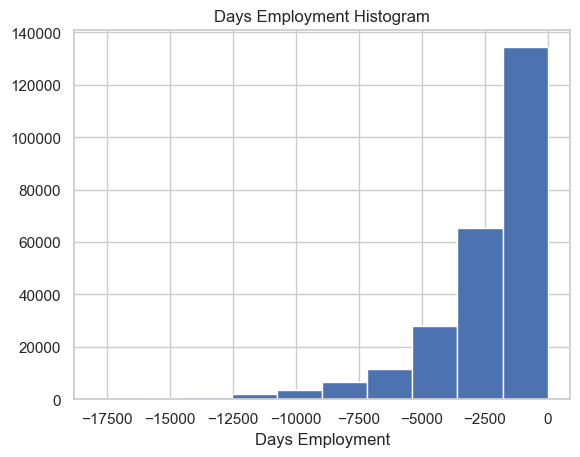

In [569]:
fig, ax = plt.subplots()

ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')
plt.show()

In [570]:
# Subset the extreme values and see if the target is different
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.07% of loans
The anomalies default on nan% of loans
There are 0 anomalous days of employment


How to correct these outliers ? Since we're missing business information on this, the safest way to deal with it is to replace with NaN and proceed to an imputation before the predictive model. Here, these outliers have the same value. Is there a link between all these rows? We'll keep a track of this information by adding a variable indicating wether or not this value was normal or not.

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1687167807.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


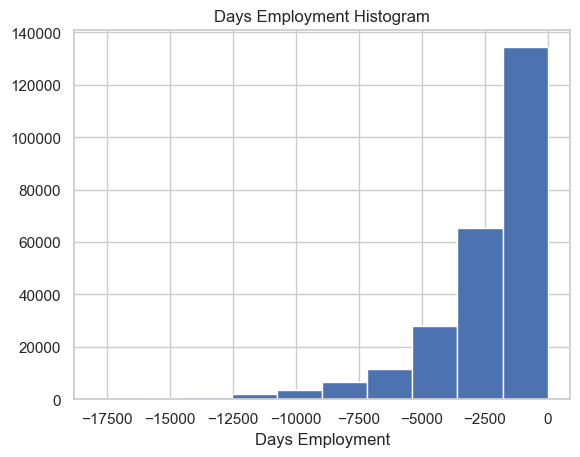

In [571]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

fig, ax = plt.subplots()
ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')

plt.show()

In [572]:
application_train[quantitative_vars].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,252133.000000,...,307507.000000,307507.000000,307507.000000,307507.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,-2384.142254,...,0.008130,0.000595,0.000507,0.000335,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,2338.327666,...,0.089799,0.024388,0.022518,0.018299,0.083850,0.110758,0.204686,0.915994,0.794060,1.869286
min,100002.000000,0.00000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Apply changes to application_trest

In [573]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test)))

There are 0 anomalies in the test data out of 48744 entries


/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1365247110.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)


## Correlations with target

In [574]:
correlations = application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 FLAG_DOCUMENT_3                                      0.044341
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_EMP_PHONE                                       0.045984
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_WORK_CITY                               0.050992
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER                                          0.054710
DAYS_LAST_PHONE_CHANGE                               0.055219
NAME_INCOME_TYPE_Working                             0.057483
REGION_RATING_CLIENT                                 0.058901
REGION_RATING_CLIENT_W_CITY                          0.060895
DAYS_EMPLOYED                                        0.074957
DAYS_BIRTH                                           0.078242
TARGET                                               1.000000
DAYS_EMPLOYED_ANOM                                        NaN
Name: TARGET, dtype: float64

Most Negati

### The age

The age seems to me the most correlated variable. It is expressed in days and is negative. For better understanding, let's take the absolute value.

In [575]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

np.float64(-0.07824216003619376)

The trend of repaying a loans grows with the client age. 

Let's understand the repartition of clients age in ur dataset

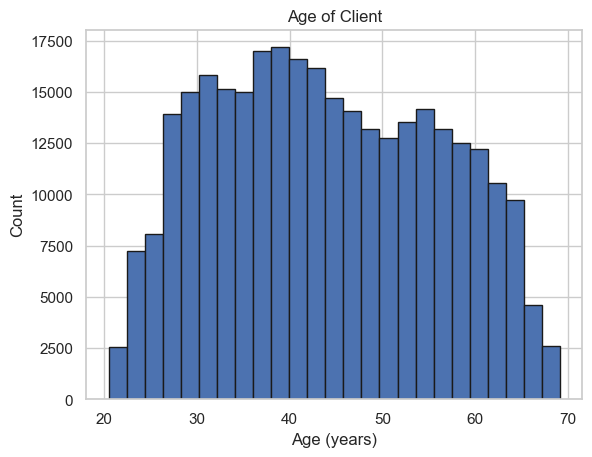

In [576]:
# set seaborn grid style
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()

ax.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)

ax.set_title('Age of Client')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')

plt.show()

No outliers and ages are in a reasonable range.

Using KDE to visualie the effect of the age on the target.

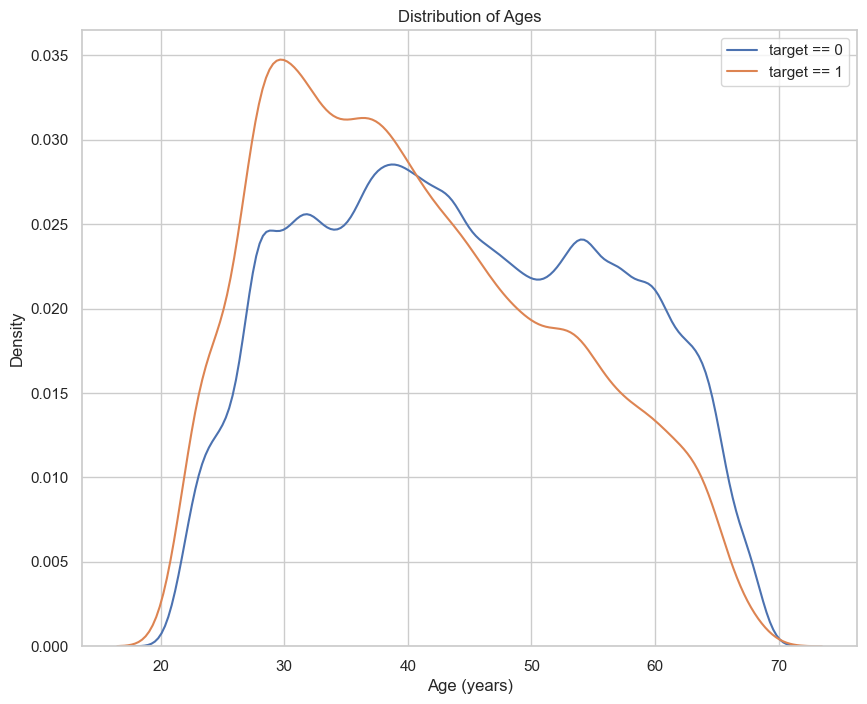

In [577]:
# Kernel density estimation
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Ages')

plt.show()

Even though the correlation coefficient is low, we notice that the curve is skewed toward the younger end of the range for target == 1.

Let's understand the the average failure to repay a loan by age brackets.

In [578]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Cut the age into bins of 5 years each
age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1512388715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1512388715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [579]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1757995694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111442,10155.219690,27.822520
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089416,13707.908041,37.555912
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055316,20984.285455,57.491193
"(60.0, 65.0]",0.052737,22780.547460,62.412459


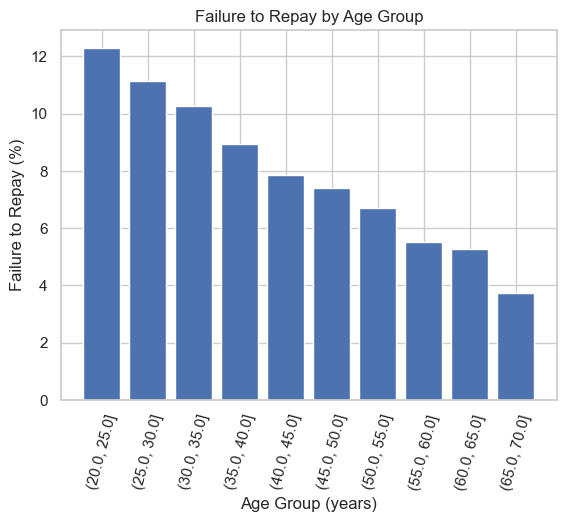

In [580]:
fig, ax = plt.subplots()

ax.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

ax.set_title('Failure to Repay by Age Group')
ax.set_xlabel('Age Group (years)')
ax.set_ylabel('Failure to Repay (%)')
# rotate x ticks
plt.xticks(rotation = 75)

plt.show()

We can clearly observe the trend that youngers are more likely to not repay their loan

### External ressources

External csources are the most negavely correlated to the target. What are those ?

In [581]:
# According to the documentation
application_description[application_description['Row'].isin(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])][["Row", "Description", "Special"]]

,Row,Description,Special
44,EXT_SOURCE_1,Normalized score from external data source,normalized
45,EXT_SOURCE_2,Normalized score from external data source,normalized
46,EXT_SOURCE_3,Normalized score from external data source,normalized


Doesn't give much information. How do they play around the target and other correlated variable ?

Text(0.5, 1.0, 'Correlation Heatmap')

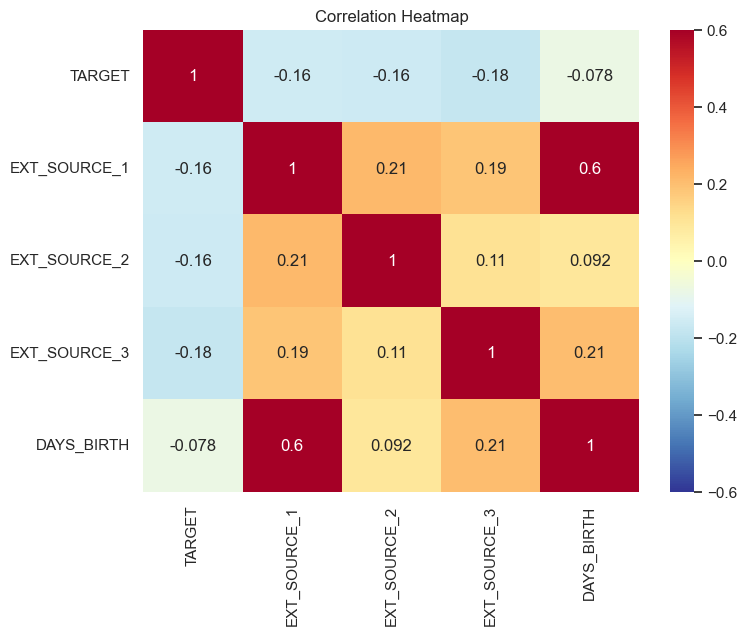

In [582]:
# get correlation of the EXT_SOURCE features with the target and plot them
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.6, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

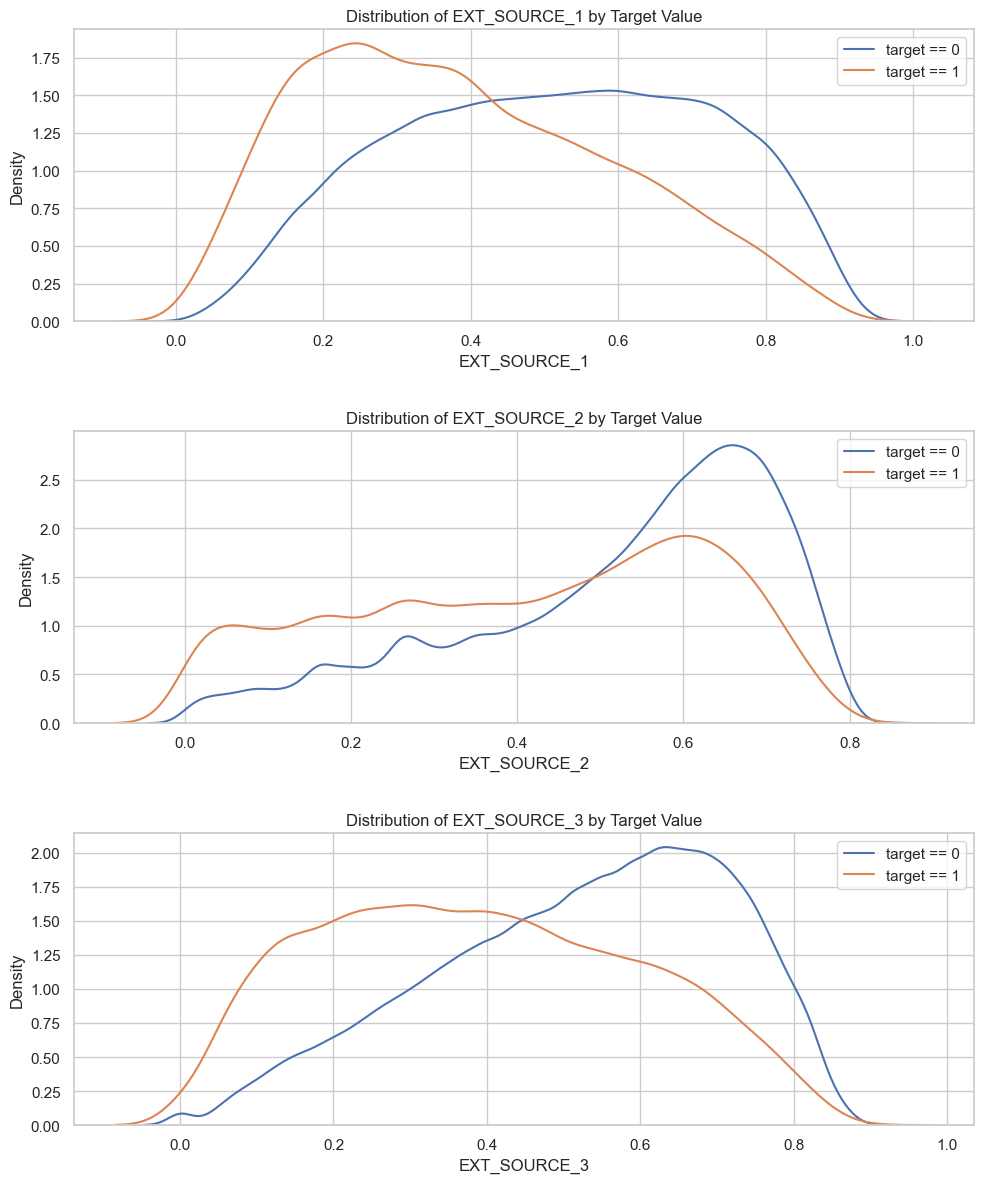

In [583]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad = 2.5)

# Features engineering

##  Simple new features 

In [584]:
# app_train_domain = application_train.copy()
# app_test_domain = application_test.copy()

# # Ratio of credit amount compared to income
# app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
# # Ratio of annuity amount compared to income
# app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
# # Ratio of credit amount compared to annuity amount
# app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
# # The ratio of days work in a life
# app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [585]:
# app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
# app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
# app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
# app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [586]:
# plt.figure(figsize = (12, 20))
# # iterate through the new features
# for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
#     # create a new subplot for each source
#     plt.subplot(4, 1, i + 1)
#     # plot repaid loans
#     sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
#     # plot loans that were not repaid
#     sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

#     # Label the plots
#     plt.title('Distribution of %s by Target Value' % feature)
#     plt.xlabel('%s' % feature)
#     plt.ylabel('Density')
#     plt.legend()

#     plt.show()

# Imputations

As we are going to work on a smaller dataset, we proceed first to the missing values imputations, then we will work using pipelines.

In [587]:
from sklearn.impute import SimpleImputer

train = application_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = application_test.copy()

In [588]:
# Median imputation of missing values because this is a method which is less impacted by outliers
imputer = SimpleImputer(strategy="median")

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
# test = imputer.transform(test)

# Add the target back in
train = pd.DataFrame(train, columns=features)

In [589]:
print("Application shape: ", application_train.shape)
print("Training data shape: ", train.shape)
# print("Testing data shape: ", test.shape)

Application shape:  (307507, 240)
Training data shape:  (307507, 240)


# Modelisation

In [653]:
# Creat a dataframe that will store the results
results = pd.DataFrame(
    columns=[
        "Shape",
        "Model",
        "Sampling_strategy",
        "Accuracy",
        "precision",
        "recall",
        "Custom_recall",
        "ROC_AUC",
    ]
)

In [652]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, make_scorer, precision_score, accuracy_score, recall_score
from imblearn.base import BaseSampler
from imblearn.pipeline import Pipeline as imbPipeline

def cost_score(y_true, y_pred):
    """Custom scoring method to add a cost to false negatives

    Args:
        y_true (): TARGET
        y_pred (): predicted values

    Returns:
        int: score
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # precision = 0 if tp + fp == 0 else (tp / (tp + fp))

    # Penalize false negatives by a factor of 10
    weighted_recall = tp / (tp + (10 * fn))
    # if precision + weighted_recall == 0:
    #     return 0
    # weighted_f1 = 2 * (precision * weighted_recall) / (precision + weighted_recall)
    return weighted_recall

# Create a scorer object that will be used instead of the default scoring metrics in sklearn
custom_scorer = make_scorer(cost_score, greater_is_better=True)
# Define a custom scorer for precision with zero_division set to 1
custom_precision_scorer = make_scorer(precision_score, zero_division=1)

metrics = ['accuracy']

def train_model(X, y, model, results, sampling_strategy=None, folds=10):
    """
    Train a model using the given data
    args:
        X : training data
        y : target
        model : model to train or pipeline
        results : DataFrame to store the results
        balance_technique : technique to balance the data
        folds : number of folds for cross-validation
    return:
        results : DataFrame with the results
    """
    estimator = model
    X = X.copy()
    y = y.copy()
    if sampling_strategy and not isinstance(sampling_strategy, str):
        # Check if the pipeline contains a resampling step
        resampling_steps = [
            step for step in model.steps if isinstance(step[1], BaseSampler)
        ]
        if resampling_steps:
            # Fit the pipeline up to the sampling step
            pipeline_up_to_sampling = imbPipeline(
                model.steps[:-1]
            )  # Exclude the classifier
            X_transformed, y_transformed = pipeline_up_to_sampling.fit_resample(X, y)

            # Print the shape of X after applying the sampling strategy
            X_shape = X_transformed.shape
        else:
            X_transformed, y_transformed = X, y
    X_shape = X.shape
    # Scoring metrics
    scoring = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "custom_recall": custom_scorer,
        "recall": "recall",
        "precision": custom_precision_scorer,
    }

    cv_scores = cross_validate(estimator, X, y, scoring=scoring, cv=folds, return_train_score=True, verbose=1)
    print(f'For {folds} folds :')
    print("Mean cross validation scores:")
    for metric in scoring:
        print(f"{metric} : {np.mean(cv_scores[f'test_{metric}'])}")

    # Fit the model
    estimator.fit(X, y)
    y_train_pred = cross_val_predict(estimator, X, y, cv=folds)
    matrix = confusion_matrix(y, y_train_pred, labels=estimator.classes_)
    disp = ConfusionMatrixDisplay(matrix, display_labels=estimator.classes_)
    disp.plot()
    disp.ax_.set_title(f"Confusion matrix for {model.__class__.__name__}")
    plt.show()

    # Calculate and print the custom metric
    custom_score = cost_score(y, y_train_pred)
    accuracy= accuracy_score(y, y_train_pred)
    recall = recall_score(y, y_train_pred)
    precision = precision_score(y, y_train_pred)

    # Complement recall metric with additional information about the model's overall discriminative ability
    # ROC AUC score helps to understand how wel the model can distinguish between classes without being overly influenced by the chosen threshold
    rocauc_score = roc_auc_score(y, y_train_pred)
    print(f"ROC AUC score: {rocauc_score}")
    # Create a new DataFrame with the results
    if model.__class__.__name__ == "Pipeline":
        model_name = model.steps[-1][1]
    else:
        model_name = model.__class__.__name__
    new_results = pd.DataFrame(
        [
            {
                "Shape": X_shape,
                "Model": model_name,
                "Sampling_strategy": sampling_strategy,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "Custom_recall": custom_score,
                "ROC_AUC": rocauc_score,
            }
        ]
    )

    # Check if results DataFrame is empty or contains only NA values
    if results.empty or results.isna().all().all():
        results = new_results
    else:
        results = pd.concat([results, new_results], ignore_index=True)

    # print(results)
    return results

## Create subsets to test

In [608]:
from sklearn.model_selection import train_test_split

def subset_data(data,proportion_to_drop,random_state=42):
    """
    Subset the data to reduce the size
    args:
        data : DataFrame
        test_size : proportion of the data to drop
        n : number of samples
    return:
        X : subset of the data
        y : subset of the target
    """
    # create a subset using stratified sampling to keep the same distribution
    subset, _ = train_test_split(
        data,
        test_size=proportion_to_drop,
        stratify=data["TARGET"],
        random_state=random_state,
    )

    # Distribution in the subset
    subset_distribution = subset["TARGET"].value_counts(normalize=True)
    print(
        f"\nSubset shape: {subset.shape[0]}\nSubset Distribution:\n",
        subset_distribution,
    )

    X_train = subset.drop(columns=["TARGET"])
    y_train = subset["TARGET"]

    return subset, X_train, y_train

In order to test the regularity of our models, we will test on several data subsets

In [609]:
original_distribution = train["TARGET"].value_counts(normalize=True)
print(f"Dataset shape: {train.shape[0]}\nOriginal Distribution:\n{original_distribution}")
# Create a subset of 10% of our training dataset respecting the target distribution
print("For a small subset keeping 10% of the data.")
small_subset, X_small, y_small = subset_data(train, 0.9)
print("For a small subset with a different random state.")
random_subset, X_random, y_random = subset_data(train, 0.9, random_state=0)
print("For a big subset keeping around 100 000 rows, so 65% of the data.")
big_subset, X_big, y_big = subset_data(train, 0.65)


Dataset shape: 307507
Original Distribution:
TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64
For a small subset keeping 10% of the data.

Subset shape: 30750
Subset Distribution:
 TARGET
0.0    0.919285
1.0    0.080715
Name: proportion, dtype: float64
For a small subset with a different random state.

Subset shape: 30750
Subset Distribution:
 TARGET
0.0    0.919285
1.0    0.080715
Name: proportion, dtype: float64
For a big subset keeping around 100 000 rows, so 65% of the data.

Subset shape: 107627
Subset Distribution:
 TARGET
0.0    0.919267
1.0    0.080733
Name: proportion, dtype: float64


## Plain simple models

For 10 folds :
Mean cross validation scores:
accuracy : 0.9192845528455285
roc_auc : 0.5
custom_recall : 0.0
recall : 0.0
precision : 1.0


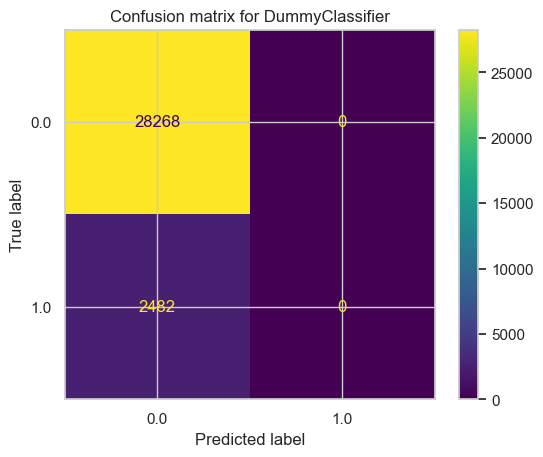

ROC AUC score: 0.5


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev

For 10 folds :
Mean cross validation scores:
accuracy : 0.9192845528455285
roc_auc : 0.628999797963667
custom_recall : 0.0
recall : 0.0
precision : 1.0


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

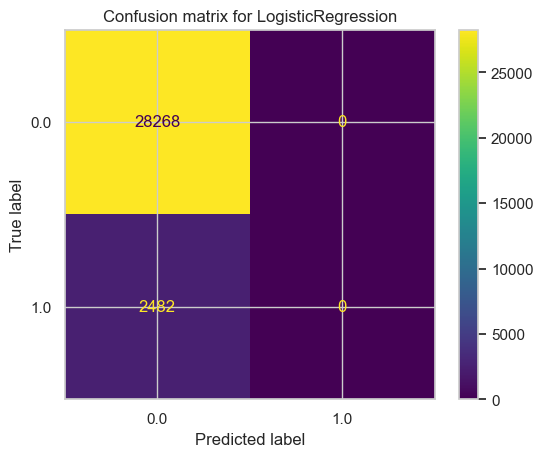

ROC AUC score: 0.5


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",DummyClassifier,None,0.919285,0.0,0.0,0.0,0.5
1,"(30750, 239)",LogisticRegression,None,0.919285,0.0,0.0,0.0,0.5


In [635]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display


simple_models = [DummyClassifier(strategy="most_frequent"), LogisticRegression()]

for model in simple_models :
    pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("model", model)])
    results = train_model(X_small, y_small, model, results)

display(results)

With a dummy classifier, our accuracy is excellent. However, using the most frequent strategy, we expect ou classifier to predict 100% of the most frequen classe, here 0, meaning 'goog client'.

In the confusion matrix, none of data predicted were 0, so number of TP = 0 and recall = 0

We can notice that the model doesn't predict any dangerous clients. Probably due to our very imbalanced dataset. What happens if we work on that ?

## Test the stability of the model

### Changing random state

For 10 folds :
Mean cross validation scores:
accuracy : 0.9190243902439026
roc_auc : 0.725623559744333
custom_recall : 0.0008963945062145076
recall : 0.008866109599689078
precision : 0.4223809523809524


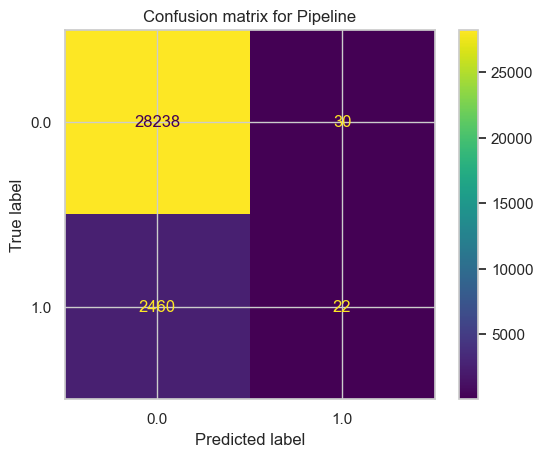

ROC AUC score: 0.5039012744028122


In [636]:
pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("model", LogisticRegression())])
results = train_model(X_random, y_random, pipeline, results)

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.9191095219892264
roc_auc : 0.7399918022540951
custom_recall : 0.0009761386935903972
recall : 0.009666945957268538
precision : 0.4550032360215427


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

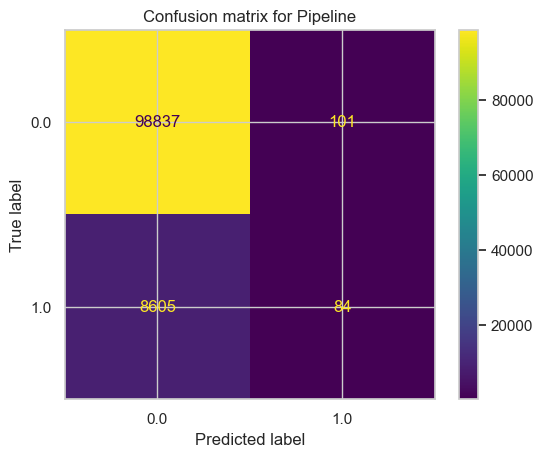

ROC AUC score: 0.5043232771113121


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",DummyClassifier,None,0.919285,0.000000,0.000000,0.000000,0.500000
1,"(30750, 239)",LogisticRegression,None,0.919285,0.000000,0.000000,0.000000,0.500000
2,"(30750, 239)",LogisticRegression(),None,0.919024,0.423077,0.008864,0.000894,0.503901
3,"(107627, 239)",LogisticRegression(),None,0.919110,0.454054,0.009667,0.000975,0.504323


In [637]:
pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("model", LogisticRegression())])
results = train_model(X_big, y_big, pipeline, results)
display(results)

# Balancing the dataset

### Manual sampling

In [625]:
class_count_0, class_count_1 = big_subset['TARGET'].value_counts()

class_0 = big_subset[big_subset["TARGET"] == 0]
class_1 = big_subset[big_subset["TARGET"] == 1]

print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (98938, 240)
class 1: (8689, 240)


#### Undersampling

Random under-sampling:
TARGET
0.0    8689
1.0    8689
Name: count, dtype: int64


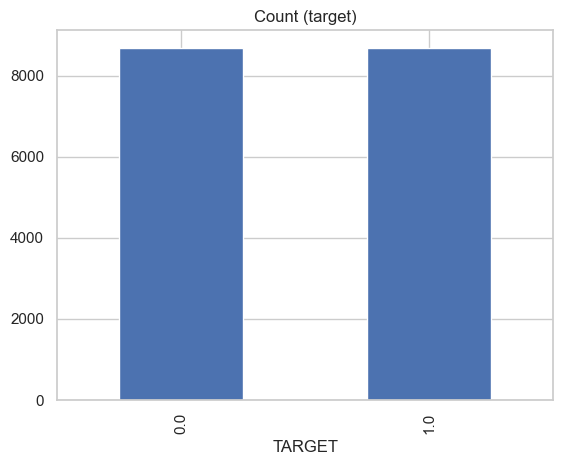

In [626]:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)
under_count = test_under['TARGET'].value_counts()

print("Random under-sampling:")
print(under_count)

under_count.plot(kind='bar', title='Count (target)')
plt.show()

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.6797099677830314
roc_auc : 0.7418629290740498
custom_recall : 0.17050690117738088
recall : 0.6722290571820992
precision : 0.6825961967976582


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

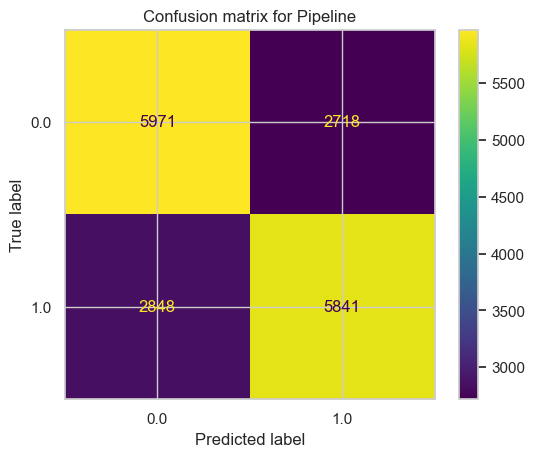

ROC AUC score: 0.6797099781332719


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",DummyClassifier,None,0.919285,0.000000,0.000000,0.000000,0.500000
1,"(30750, 239)",LogisticRegression,None,0.919285,0.000000,0.000000,0.000000,0.500000
2,"(30750, 239)",LogisticRegression(),None,0.919024,0.423077,0.008864,0.000894,0.503901
3,"(107627, 239)",LogisticRegression(),None,0.919110,0.454054,0.009667,0.000975,0.504323
4,"(17378, 239)",LogisticRegression(),Manual Under-sampling,0.679710,0.682440,0.672229,0.170187,0.679710


In [639]:
pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("model", LogisticRegression())])
results = train_model(test_under.drop(columns=["TARGET"]), test_under["TARGET"], pipeline, results, sampling_strategy='Manual Under-sampling')
display(results)

The problem with undersampling is that we are losing a lot of data by not working with all our discarded target.

#### Oversampling

Random over-sampling:
TARGET
1.0    98938
0.0    98938
Name: count, dtype: int64


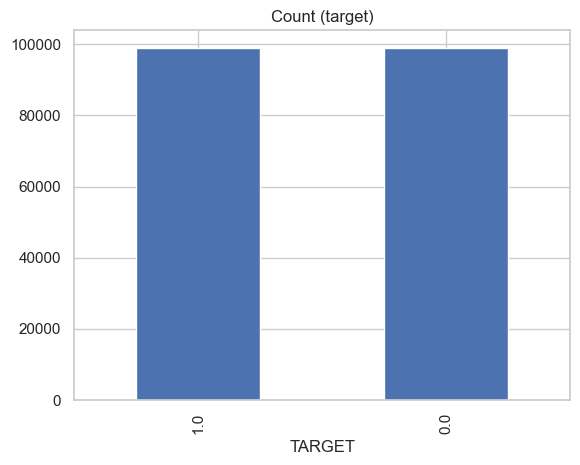

In [628]:
class_1_over = class_1.sample(class_count_0, replace=True)
test_over = pd.concat([class_1_over, class_0], axis=0)
over_count = test_over['TARGET'].value_counts()
print("Random over-sampling:")
print(over_count)

over_count.plot(kind='bar', title='Count (target)')
plt.show()

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.6836403002263167
roc_auc : 0.7471043741129314
custom_recall : 0.17478344979945473
recall : 0.6792536477483114
precision : 0.6852735484563772


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

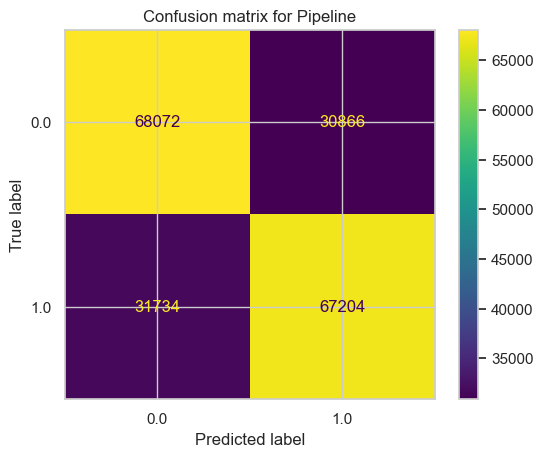

ROC AUC score: 0.6836402595564899


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",DummyClassifier,None,0.919285,0.000000,0.000000,0.000000,0.500000
1,"(30750, 239)",LogisticRegression,None,0.919285,0.000000,0.000000,0.000000,0.500000
2,"(30750, 239)",LogisticRegression(),None,0.919024,0.423077,0.008864,0.000894,0.503901
3,"(107627, 239)",LogisticRegression(),None,0.919110,0.454054,0.009667,0.000975,0.504323
4,"(17378, 239)",LogisticRegression(),Manual Under-sampling,0.679710,0.682440,0.672229,0.170187,0.679710
5,"(197876, 239)",LogisticRegression(),Manual over-sampling,0.683640,0.685266,0.679254,0.174763,0.683640


In [640]:
results = train_model(test_over.drop(columns=["TARGET"]), test_over["TARGET"], pipeline, results, sampling_strategy='Manual over-sampling')
display(results)

Manual under and over sampling don't give much results. We will explore other sampling methods. But before going further we will use the small_subset as using a subset of 100.000 rows takes some time to compute. As we saw earlier, working on a subset of 40.000 doesn't change much the metrics. 

## Using imblearn module

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.6658861788617887
roc_auc : 0.7284426131277193
custom_recall : 0.17133459065054907
recall : 0.6724494753206374
precision : 0.14996347353808218


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

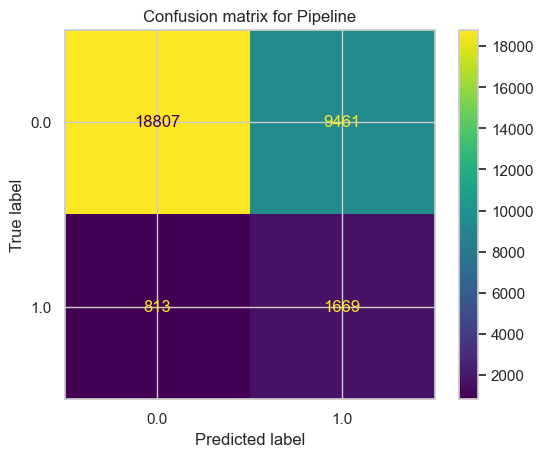

ROC AUC score: 0.6688760889640732


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.6913821138211383
roc_auc : 0.7335718611130533
custom_recall : 0.16058921526359776
recall : 0.6563317787278145
precision : 0.1588157049430094


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

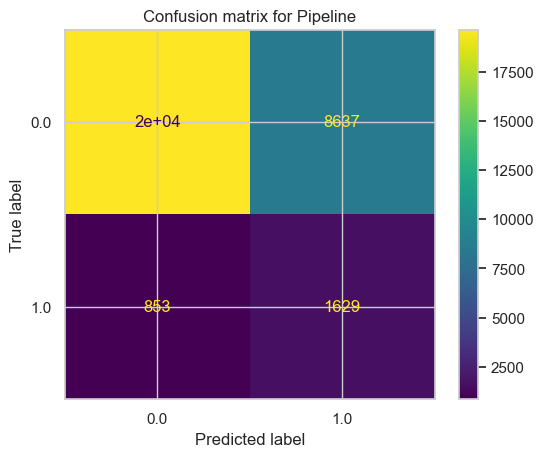

ROC AUC score: 0.6753928554447263
For 10 folds :
Mean cross validation scores:
accuracy : 0.919089430894309
roc_auc : 0.7350529843251958
custom_recall : 0.00152099331104589
recall : 0.01489182536598005
precision : 0.4284704184704185


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


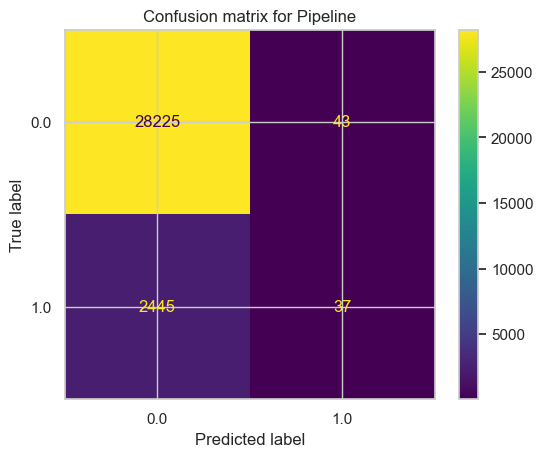

ROC AUC score: 0.5066930890668081


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.6986341463414634
roc_auc : 0.7222459333432207
custom_recall : 0.1440728130942165
recall : 0.6261206114781708
precision : 0.15711032386512164


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

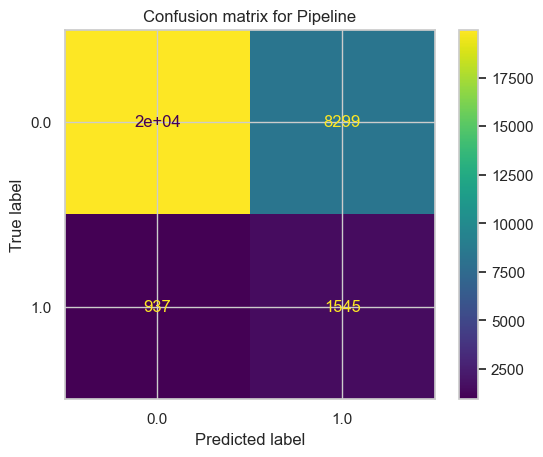

ROC AUC score: 0.6644495097972702


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.23827642276422764
roc_auc : 0.5380405061200146
custom_recall : 0.42698909812574143
recall : 0.8791423759554347
precision : 0.08622537414323277


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

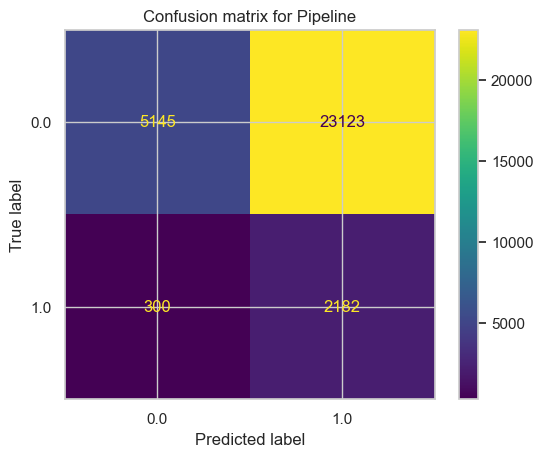

ROC AUC score: 0.5305688291199679


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",LogisticRegression(),"RandomUnderSampler(random_state=42, replacement=True)",0.665886,0.149955,0.672442,0.170324,0.668876
1,"(30750, 239)",LogisticRegression(),RandomOverSampler(random_state=42),0.691382,0.158679,0.656326,0.160350,0.675393
2,"(30750, 239)",LogisticRegression(),TomekLinks(sampling_strategy='majority'),0.919089,0.462500,0.014907,0.001511,0.506693
3,"(30750, 239)",LogisticRegression(),SMOTE(),0.699642,0.156948,0.622482,0.141548,0.664450
4,"(30750, 239)",LogisticRegression(),NearMiss(),0.238276,0.086228,0.879130,0.421073,0.530569


In [655]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks


rus = RandomUnderSampler(random_state=42, replacement=True)
ros = RandomOverSampler(random_state=42)
tl = TomekLinks(sampling_strategy="majority")
smote = SMOTE()
# smotenc = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
nm = NearMiss()

sampling_stategies = [rus, ros, tl, smote, nm]
for strategy in sampling_stategies:
    pipeline = imbPipeline(steps=[("scaler", MinMaxScaler()), ("sampling", strategy), ("model", LogisticRegression())])
    results = train_model(X_small, y_small, pipeline, results, sampling_strategy=strategy)

display(results)

### Oversampling

/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Mean cross validation scores:
accuracy : 0.6913821138211383
roc_auc : 0.7335718611130533
custom_recall : 0.16058921526359776
recall : 0.6563317787278145
precision : 0.1588157049430094


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

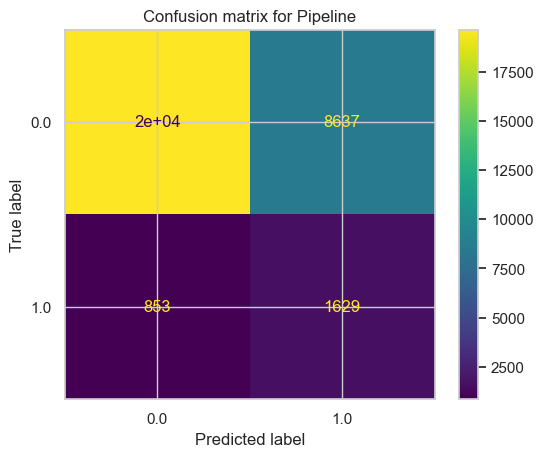

ROC AUC score: 0.6753928554447263


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",DummyClassifier,None,0.919285,0.000000,0.000000,0.000000,0.500000
1,"(30750, 239)",LogisticRegression,None,0.919285,0.000000,0.000000,0.000000,0.500000
2,"(30750, 239)",LogisticRegression(),None,0.919024,0.423077,0.008864,0.000894,0.503901
3,"(107627, 239)",LogisticRegression(),None,0.919110,0.454054,0.009667,0.000975,0.504323
4,"(17378, 239)",LogisticRegression(),Manual Under-sampling,0.679710,0.682440,0.672229,0.170187,0.679710
5,"(197876, 239)",LogisticRegression(),Manual over-sampling,0.683640,0.685266,0.679254,0.174763,0.683640
6,"(30750, 239)",LogisticRegression(),"RandomUnderSampler(random_state=42, replacement=True)",0.665886,0.149955,0.672442,0.170324,0.668876
7,"(30750, 239)",LogisticRegression(),RandomOverSampler(random_state=42),0.691382,0.158679,0.656326,0.160350,0.675393


In [650]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
pipeline = imbPipeline(steps=[("scaler", MinMaxScaler()), ("ROS",ros), ("model", LogisticRegression())])
results = train_model(X_small, y_small, pipeline, results, sampling_strategy=ros)
display(results)

### Tomek links

For 10 folds :
Mean cross validation scores:
accuracy : 0.919089430894309
roc_auc : 0.7350529843251958
custom_recall : 0.00152099331104589
recall : 0.01489182536598005
precision : 0.4284704184704185


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


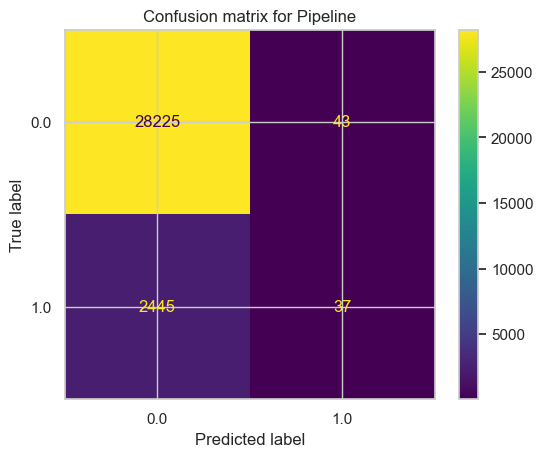

ROC AUC score: 0.5066930890668081


,Shape,Model,Sampling_strategy,Accuracy,Precision,Recall,Custom_recall,ROC_AUC
0,"(30750, 239)",DummyClassifier,None,0.919285,0.000000,0.000000,0.000000,0.500000
1,"(30750, 239)",LogisticRegression,None,0.919285,0.000000,0.000000,0.000000,0.500000
2,"(30750, 239)",LogisticRegression(),None,0.919024,0.423077,0.008864,0.000894,0.503901
3,"(107627, 239)",LogisticRegression(),None,0.919110,0.454054,0.009667,0.000975,0.504323
4,"(17378, 239)",LogisticRegression(),Manual Under-sampling,0.679710,0.682440,0.672229,0.170187,0.679710
5,"(197876, 239)",LogisticRegression(),Manual over-sampling,0.683640,0.685266,0.679254,0.174763,0.683640
6,"(30750, 239)",LogisticRegression(),"RandomUnderSampler(random_state=42, replacement=True)",0.665886,0.149955,0.672442,0.170324,0.668876
7,"(30750, 239)",LogisticRegression(),RandomOverSampler(random_state=42),0.691382,0.158679,0.656326,0.160350,0.675393
8,"(30750, 239)",LogisticRegression(),TomekLinks(sampling_strategy='majority'),0.919089,0.462500,0.014907,0.001511,0.506693


In [651]:


pipeline = imbPipeline(steps=[("scaler", MinMaxScaler()), ("TomekLinks", tl), ("model", LogisticRegression())])
results = train_model(X_small, y_small, pipeline, results, sampling_strategy=tl)
display(results)

### SMOTE

In [395]:


x_smote, y_smote = smote.fit_resample(X_train, y_train)

print(f"Original counts: {y_train.value_counts()}")
print(f"Resampled counts: {y_smote.value_counts()}")

Original counts: TARGET
0.0    28268
1.0     2482
Name: count, dtype: int64
Resampled counts: TARGET
0.0    28268
1.0    28268
Name: count, dtype: int64


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Weighted recall score: [0.17604366 0.17500579 0.17197745 0.17999413 0.17931761 0.17015917
 0.18192537 0.17150092 0.17993201 0.18241849]
Mean cross validation score: 0.17682746060832788


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

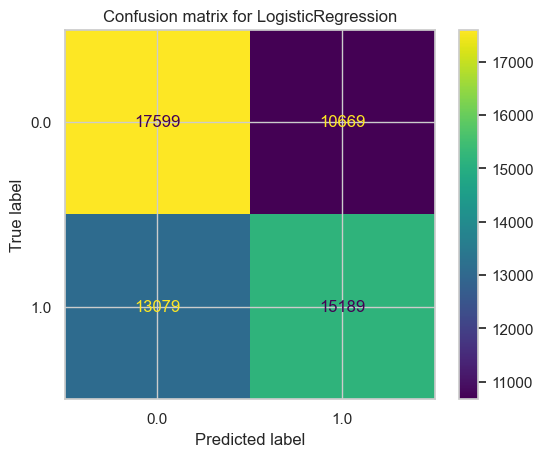

F1 weighted score: 0.17678381256656017
ROC AUC score: 0.5799490590066506
                Model   Balance_technique   ROC_AUC Custom_F1
0     DummyClassifier                None  0.500000         0
1  LogisticRegression                None  0.500000         0
2  LogisticRegression      Under-sampling  0.576551  0.173261
3  LogisticRegression       Over-sampling  0.577880  0.173876
4  LogisticRegression  RandomUnderSampler  0.569702  0.170155
5  LogisticRegression          TomekLinks  0.500000         0
6  LogisticRegression               SMOTE  0.579949  0.176784


In [396]:
resluts = train_model(x_smote, y_smote, LogisticRegression(), results, balance_technique='SMOTE')

### Nearmiss

In [397]:


x_nm, y_nm = nm.fit_resample(X_train, y_train)

print(f"Original counts: {y_train.value_counts()}")
print(f"Resampled counts: {y_nm.value_counts()}")

Original counts: TARGET
0.0    28268
1.0     2482
Name: count, dtype: int64
Resampled counts: TARGET
0.0    2482
1.0    2482
Name: count, dtype: int64


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Weighted recall score: [0.21218638 0.24629774 0.22353812 0.21656977 0.27079935 0.23123123
 0.2624     0.24401544 0.2611465  0.23963134]
Mean cross validation score: 0.24078158628929386


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

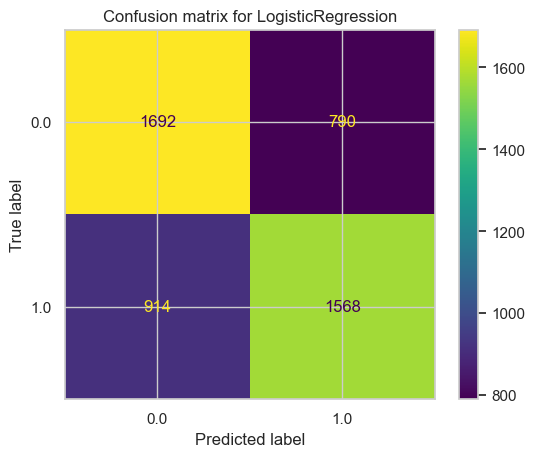

F1 weighted score: 0.2400122455227307
ROC AUC score: 0.6567284448025786
                Model   Balance_technique   ROC_AUC Custom_F1
0     DummyClassifier                None  0.500000         0
1  LogisticRegression                None  0.500000         0
2  LogisticRegression      Under-sampling  0.576551  0.173261
3  LogisticRegression       Over-sampling  0.577880  0.173876
4  LogisticRegression  RandomUnderSampler  0.569702  0.170155
5  LogisticRegression          TomekLinks  0.500000         0
6  LogisticRegression            NearMiss  0.656728  0.240012


In [398]:
results = train_model(x_nm, y_nm, LogisticRegression(), results, balance_technique='NearMiss')

## Combining SMOT & random undersampling

In [400]:
from collections import Counter
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipline = Pipeline(steps=steps)

X_p, y_p = pipline.fit_resample(X_train, y_train)
print(Counter(y_p))

Counter({0.0: 5652, 1.0: 2826})


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

For 10 folds :
Weighted recall score: [0.0080292  0.00359195 0.00285714 0.00504141 0.00651702 0.00141995
 0.00213371 0.00430416 0.00432432 0.00214056]
Mean cross validation score: 0.0040359433866795575


/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laetitiataddei/Desktop/code/Laeti-dev/data/P4_Credit-Scoring-Model/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

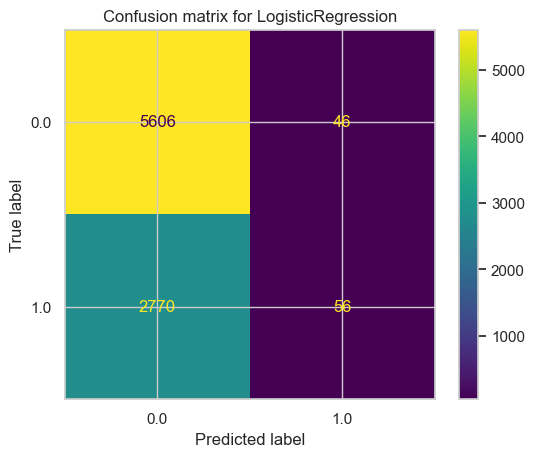

F1 weighted score: 0.004020389116232322
ROC AUC score: 0.5058386411889597
                Model           Balance_technique   ROC_AUC Custom_F1
0     DummyClassifier                        None  0.500000         0
1  LogisticRegression                        None  0.500000         0
2  LogisticRegression              Under-sampling  0.576551  0.173261
3  LogisticRegression               Over-sampling  0.577880  0.173876
4  LogisticRegression          RandomUnderSampler  0.569702  0.170155
5  LogisticRegression                  TomekLinks  0.500000         0
6  LogisticRegression                    NearMiss  0.656728  0.240012
7  LogisticRegression  SMOTE + RandomUnderSampler  0.505839   0.00402


In [401]:
results = train_model(X_p, y_p, LogisticRegression(), results, balance_technique='SMOTE + RandomUnderSampler')

For 10 folds :
Weighted recall score: [0.28837998 0.30933333 0.30366492 0.29502573 0.36469447 0.34360411
 0.31233363 0.34839925 0.36049856 0.33860465]
Mean cross validation score: 0.3264538635332541


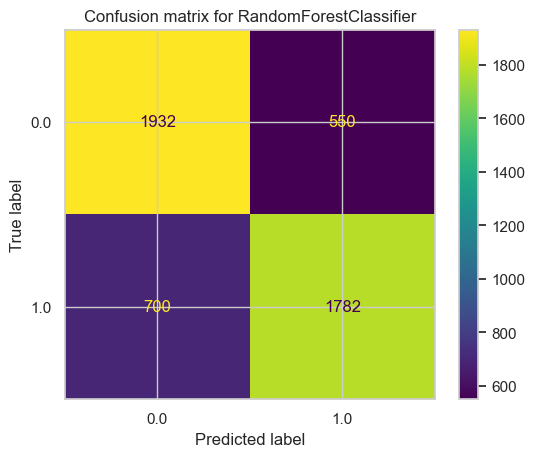

F1 weighted score: 0.3206766240777398
ROC AUC score: 0.7481869460112812
                    Model           Balance_technique   ROC_AUC Custom_F1
0         DummyClassifier                        None  0.500000         0
1      LogisticRegression                        None  0.500000         0
2      LogisticRegression              Under-sampling  0.576551  0.173261
3      LogisticRegression               Over-sampling  0.577880  0.173876
4      LogisticRegression          RandomUnderSampler  0.569702  0.170155
5      LogisticRegression                  TomekLinks  0.500000         0
6      LogisticRegression                    NearMiss  0.656728  0.240012
7      LogisticRegression  SMOTE + RandomUnderSampler  0.505839   0.00402
8  RandomForestClassifier                    NearMiss  0.748187  0.320677


In [404]:
from sklearn.ensemble import RandomForestClassifier

results = train_model(
    x_nm, y_nm, RandomForestClassifier(), results, balance_technique="NearMiss"
)


The near miss method seems to be the more efficient. Now lets create a pipeline to worl on our datas and try several models for the prediction.

## Create pipeline

In [424]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

In [425]:
pipeline = ImbPipeline(
    [
        ("scaler", MinMaxScaler()),
        ("smote", SMOTE(random_state=42)),
        ("nearmiss", NearMiss),
        ("classifier", LogisticRegression()),
    ]
)

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2", "elasticnet", "none"],
    "classifier__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__l1_ratio": [None, 0.1, 0.5, 0.7, 0.9],
}

scoring = { 'roc_auc': 'roc_auc', 'f1_weighted': custom_scorer }

In [429]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)

# Get the results for all scoring metrics
results = grid_search.cv_results_
print("Mean test scores for ROC AUC: ", results["mean_test_roc_auc"])
print("Mean test scores for custom F1: ", results["mean_test_custom_f1"])

TypeError: BaseEstimator.get_params() missing 1 required positional argument: 'self'

# Features importance

In [416]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
    """

    # Sort features according to importance
    df = df.sort_values("importance", ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df["importance_normalized"] = df["importance"] / df["importance"].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(
        list(reversed(list(df.index[:15]))),
        df["importance_normalized"].head(15),
        align="center",
        edgecolor="k",
    )

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df["feature"].head(15))

    # Plot labeling
    plt.xlabel("Normalized Importance")
    plt.title("Feature Importances")
    plt.show()

    return df


In [ ]:
feature_importances = plot_feature_importances()